# TODO:

Take all the changes in model.py and export to standalone functions for now.

Once that's ready, load the model from huggingface to see if it can handle this.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import numpy as np
import torch
from torch.optim import AdamW
from visualization_utils import plot_sample, plot_prediction
from moondream_functions import detect, detect_grad
from dataset import load_object_detection_dataset
from moondream_cache import setup_caches
torch.autograd.set_detect_anomaly(True)
hf_model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-06-21",
    trust_remote_code=True,
    device_map={"": "mps"}  # ...or 'mps', on Apple Silicon
)



/Users/noahkasmanoff/anaconda3/envs/torch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from pretrained vikhyatk/moondream2
config None
pretrained_model_name_or_path vikhyatk/moondream2
has_remote_code and trust_remote_code
model_class <class 'transformers_modules.vikhyatk.moondream2.9a7d4024050840e001defacec2b00727e89149e6.hf_moondream.HfMoondream'>


In [2]:
optimizer = AdamW(hf_model.model.region.parameters(), lr=1e-5)

num_params = sum(p.numel() for p in hf_model.model.region.parameters())
print(f"Number of parameters: {num_params:,}")

Number of parameters: 60,317,312


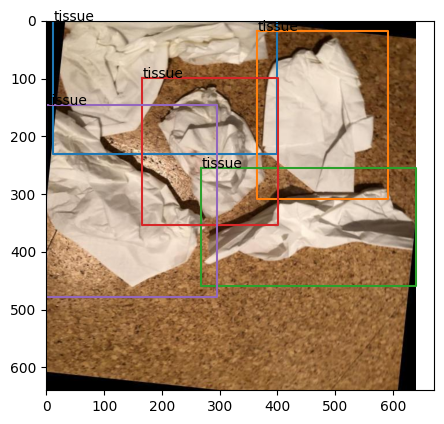

In [3]:
train_ds = load_object_detection_dataset("train")


sample = train_ds[11]

plot_sample(sample)


In [4]:
hf_model._setup_caches()

# Data collection

In [5]:
from rl_utils import calculate_reward

BATCH_SIZE = 1
NUM_ROLLOUTS = 2
experience = []
for i in range(BATCH_SIZE):
    sample = train_ds[11]
#    hf_model.encode_image(sample[0], None); # initalize the  kv_cache for this sample

    trajectory_detections = []

    for i in range(NUM_ROLLOUTS):
        detections = detect(hf_model.model, sample[0], sample[1], None, temperature=1)
        trajectory_detections.append(detections)

    rewards = calculate_reward(trajectory_detections, sample)
    advantages = rewards - np.mean(rewards)

    advantages = advantages / np.std(advantages)

    advantages = torch.tensor(advantages, dtype=torch.float32).to(hf_model.model.device)
    advantages = advantages.unsqueeze(1)

    group_experience = []
    for i, traj in enumerate(trajectory_detections):
        predictions = traj['objects']
        advantage = advantages[i]
        logprobs = []
        for obj in predictions:
            x_logprob = obj['x_logprob']
            y_logprob = obj['y_logprob']
            w_logprob = obj['w_logprob']
            h_logprob = obj['h_logprob']
            logprobs.extend([x_logprob, y_logprob, w_logprob, h_logprob])

        # convert logits list to tensor
        logprobs = torch.tensor(logprobs, dtype=torch.float32).to(hf_model.model.device)
        group_experience.append({'logprobs': logprobs, 'advantage': advantage})
    experience.extend(group_experience)



# Training Step

In [7]:
# will need to do this for each sample in the batch, and then average the loss
from rl_utils import calculate_gpro_loss
import torch

optimizer.zero_grad()
total_loss = 0

for i in range(BATCH_SIZE):
    sample = train_ds[11]

    new_predictions = detect_grad(hf_model.model, sample[0], sample[1], None, temperature=0)
    new_logprobs = torch.stack(new_predictions['out_logprobs']).reshape(-1, len(new_predictions['out_logprobs']))


    old_logprobs_stack = [] # the prior log probs for the same corresponding sample
    advantages_stack = []
    # truncate experience to only be for this sample
    trajectory_experience = experience[i*NUM_ROLLOUTS:(i+1)*NUM_ROLLOUTS]


    attention_mask = torch.ones(len(trajectory_experience), new_logprobs.shape[-1], device=hf_model.model.device)

    for j in range(len(trajectory_experience)):

        # todo add padding and some kind of masking during gradient calculation
        group_experience_logprobs = trajectory_experience[j]['logprobs']
        orig_len = len(group_experience_logprobs)
        # pad right with 0s to match new_logprobs.shape[-1]
        if orig_len < new_logprobs.shape[-1]:
            group_experience_logprobs = torch.cat([group_experience_logprobs, torch.zeros(new_logprobs.shape[-1] - orig_len, device=hf_model.model.device)])
            # set attention mask to 0 for the padded tokens
            attention_mask[j, orig_len:] = 0
        elif orig_len > new_logprobs.shape[-1]:
            group_experience_logprobs = group_experience_logprobs[:new_logprobs.shape[-1]] # truncate
        old_logprobs_stack.append(group_experience_logprobs)
        advantages_stack.append(trajectory_experience[j]['advantage'])

    advantages = torch.stack(advantages_stack)
    old_logprobs = torch.stack(old_logprobs_stack)

    gpro_loss = calculate_gpro_loss(new_logprobs, old_logprobs, advantages, attention_mask)
    total_loss += gpro_loss

if BATCH_SIZE > 0:
    print(total_loss)
    final_loss = total_loss / BATCH_SIZE
    final_loss.backward()
    optimizer.step()

tensor(0.1230, device='mps:0', grad_fn=<AddBackward0>)


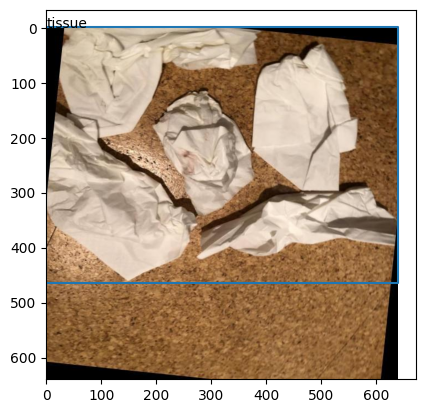

In [8]:
plot_prediction(new_predictions, sample)

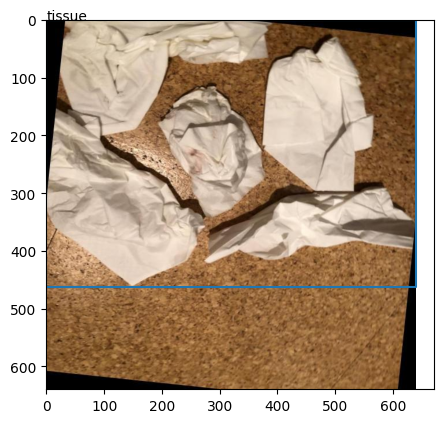

In [10]:
new_predictions = detect(hf_model.model, sample[0], sample[1], None, temperature=0)

plot_prediction(new_predictions, sample)